# comparing performance of 24, 48, 72 hour data models


In [343]:
import pandas as pd
import matplotlib.pyplot as plt
import os, sys
from pathlib import Path
import seaborn as sns
import numpy as np
import glob
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, accuracy_score, auc, precision_recall_fscore_support, pairwise, f1_score, log_loss, make_scorer
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm

#importin xg boost and all needed otherstuff
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier #conda install -c conda-forge xgboost to install
##adding these, lets see if it helps with xgboost crash
os.environ['KMP_DUPLICATE_LIB_OK']='True'

#reducing warnings that are super common in my model
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.simplefilter(action='ignore') #ignore all warnings

RANDOM_STATE = 15485867

%matplotlib inline
plt.style.use('ggplot')

from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
        'width': 1024,
        'height': 768,
        'scroll': True,
})

%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 33.2 ms


In [344]:
#patients of interest from rotation_cohort_generation
from parameters import final_pt_df_v, date, repository_path, lower_window, upper_window, folder, date, time_col, time_var, patient_df

#patients of interest from rotation_cohort_generation
final_pt_df2 = final_pt_df_v #pd.read_csv('/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/raw/csv/%s_final_pt_df2.csv'%(most_updated_patient_df), index_col=0)
del(final_pt_df_v)

patients= list(final_pt_df2['subject_id'].unique())
hadm_id= list(final_pt_df2['hadm_id'].unique())
icustay_id= list(final_pt_df2['icustay_id'].unique())
icustay_id= [int(x) for x in icustay_id]

save_boolean=False

time: 39.5 ms


## importing x and y train and test

In [323]:

def data_import(allFiles):
    """
    function to import x_train, x_test, y_train, and y_test using glob of the data/final folder.
    """
    for name in allFiles:
        if 'test' in name:
            if 'x_' in name:
                x_test = pd.read_csv(name,  index_col=0)
            else:
                 y_test = pd.read_csv(name,  index_col=0)
        elif 'train' in name:
            if 'x_' in name:
                x_train = pd.read_csv(name,  index_col=0)
            else:
                 y_train = pd.read_csv(name,  index_col=0)
    return(x_train, x_test, y_train, y_test)


time: 14.8 ms


In [324]:
#importing x and y train and test

allFiles_24 = glob.glob(str(repository_path)+ '/data/final/%s/'%('24_hr_window') + "*.csv")
allFiles_48 = glob.glob(str(repository_path)+ '/data/final/%s/'%('48_hr_window') + "*.csv")
allFiles_72 = glob.glob(str(repository_path)+ '/data/final/%s/'%('72_hr_window') + "*.csv")

x_train_24, x_test_24, y_train_24, y_test_24= data_import(allFiles_24)
x_train_48, x_test_48, y_train_48, y_test_48= data_import(allFiles_48)
x_train_72, x_test_72, y_train_72, y_test_72= data_import(allFiles_72)

time: 656 ms


## importing all models and storing them in dictionary

In [325]:
def load_model(filename, timewindow):
    import pickle
    loaded_modle= pickle.load(open(filename, 'rb'))
    return(loaded_modle)

time: 1.93 ms


In [326]:
models_24 = glob.glob(str(repository_path)+ '/models/%s/'%('24_hr_window')+'*')
models_48 = glob.glob(str(repository_path)+ '/models/%s/'%('48_hr_window')+'*')
models_72 = glob.glob(str(repository_path)+ '/models/%s/'%('72_hr_window')+'*')

models_24_dic={}
models_48_dic={}
models_72_dic={}

for model in models_24:
    models_24_dic.update( {model.strip('.sav').split('_')[-1] : load_model(model, '24_hr_window')} )
    
for model in models_48:
    models_48_dic.update( {model.strip('.sav').split('_')[-1] : load_model(model, '48_hr_window')} )

for model in models_72:
    models_72_dic.update( {model.strip('.sav').split('_')[-1] : load_model(model, '72_hr_window')} )

time: 825 ms


# importing and testing classifier eval fxn

In [327]:
def optimal_youden_index(fpr, tpr, thresholds, tp90=True):
    """
    inputs fpr, tpr, thresholds from metrics.roc(),
    outputs the clasification threshold, roc dataframe, and the index of roc dataframe for optimal youden index
    """
    #making dataframe out of the thresholds
    roc_df= pd.DataFrame({"thresholds": thresholds,"fpr":fpr, "tpr": tpr})
    roc_df.iloc[0,0] =1
    roc_df['yuden']= roc_df['tpr']-roc_df['fpr']
    
    if tp90==True:
        idx= roc_df[roc_df['tpr']>=0.9]['yuden'].idxmax() #changed this so now finds optimial yuden threshold but tp>=90%
    else:
        idx=roc_df['yuden'].idxmax() #MAX INDEX
    
    youden_threshold=roc_df.iloc[idx,0] #threshold for max youden
    return(youden_threshold, roc_df, idx)
    
def plot_roc(fpr, tpr, roc_auc, roc_df, idx, save=False,model_name=None, folder_name=None, file_name=None):
    plt.title('ROC with optimal Youden Index')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    
    #finding the point on the line given threshold 0.5 (finding closest row in roc_df)
    og_idx=roc_df.iloc[(roc_df['thresholds']-0.5).abs().argsort()[:1]].index[0]
    plt.plot(roc_df.iloc[og_idx,1], roc_df.iloc[og_idx,2],marker='x', markersize=5, color="g")
    plt.annotate(s="P(>=0.5)",xy=(roc_df.iloc[og_idx,1]+0.02, roc_df.iloc[og_idx,2]-0.04),color='g') #textcoords
    
    plt.plot(roc_df.iloc[idx,1], roc_df.iloc[idx,2],marker='o', markersize=5, color="r") ##
    plt.annotate(s="M_Youden",xy=(roc_df.iloc[idx,1]+0.02, roc_df.iloc[idx,2]-0.04),color='r' ) #textcoords
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    
    if save==True:
        saveplot(plt, figure_name="{}_roc".format(model_name))
    else: pass
    
    plt.show()

time: 80.7 ms


In [328]:
def youden_predict(model, x, y, pos_label=1):
    import sklearn.metrics as metrics
    y_proba = model.predict_proba(x)[:,1]
    
    fpr, tpr, thresholds = metrics.roc_curve(y, y_proba, pos_label=pos_label)
    roc_auc = metrics.auc(fpr, tpr)
    
    #gathering the optimal youden_index and df of tpr/fpr for auc and index of that optimal youden. idx is needed in the roc
    youden_threshold, roc_df, idx= optimal_youden_index(fpr, tpr, thresholds,tp90=True)
    
    y_pred_youden = [1 if y >= youden_threshold else 0 for y in y_proba]
    
    return(y_pred_youden)

time: 18.5 ms


In [329]:
def classifier_eval(model, x, y, proba_input=False,pos_label=1, print_default=True,model_name=None, folder_name=None):
    import sklearn.metrics as metrics
    from sklearn.metrics import precision_score, roc_auc_score, f1_score, recall_score
    """
    classification evaluation function. able to print/save the following:
    
    print/save the following:
        ROC curve marked with threshold for optimal youden (maximizing tpr+fpr with constraint that tpr>0.9)

        using 0.5 threshold:
            confusion matrix
            classification report
            npv
            accuracy

        using optimal youden (maximizing tpr+fpr with constraint that tpr>0.9):
            confusion matrix
            classification report
            npv
            accuracy
    
    output: 
        outputs modelname, auc, precision, recall, f1, and npv to a dictionary. 
    
    notes:
    youden's J statistic:
    J= sensitivity + specificity -1
    (truepos/ truepos+falseneg) + (true neg/ trueneg + falsepos) -1
    
    """
    
    if proba_input==True: 
        y_proba= model
        y_pred=[1 if y >= 0.5 else 0 for y in y_proba]
    
    else:
        model_name=type(model).__name__

        y_pred = model.predict(x)
        y_proba = model.predict_proba(x)[:,1]
        
    fpr, tpr, thresholds = metrics.roc_curve(y, y_proba, pos_label=pos_label)
    roc_auc = metrics.auc(fpr, tpr)
    
    #gathering the optimal youden_index and df of tpr/fpr for auc and index of that optimal youden. idx is needed in the roc
    youden_threshold, roc_df, idx= optimal_youden_index(fpr, tpr, thresholds,tp90=True)

    #plotting roc
    plot_roc(fpr, tpr, roc_auc, roc_df, idx, save=save_boolean, model_name=model_name,folder_name=folder)
    plt.show(), plt.close()
    
    #printing npv, recall, precision, accuracy
    npv=confusion_matrix(y, y_pred)[0,0]/sum(np.array(y_pred)==0)
    prec= precision_score(y_true=y, y_pred= y_pred, pos_label=pos_label)
    recall= recall_score(y_true=y, y_pred= y_pred, pos_label=pos_label)
    f1= f1_score(y_true=y, y_pred= y_pred, pos_label=pos_label)
    
    if print_default==True: ###can opt to not print the 0.5 classification threshold classification report/conf matrix
        #plotting confusion matrixs
        print("\n******* Using 0.5 Classification Threshold *******\n")
        print(confusion_matrix(y, y_pred))
        print ('the Accuracy is: {:01.3f}'.format(accuracy_score(y, y_pred)))
        print ("npv: {:01.3f}".format(npv))
        print ('the classification_report:\n', classification_report(y,y_pred, digits=3))
    else:
        pass
    
    #### YOUDEN ADJUSTMENT #####

    print("\n******* Using Optimal Youden Classification Threshold *******\n")
    print("\nthe Youden optimal index is : {:01.3f}".format(youden_threshold))

    y_pred_youden = [1 if y >= youden_threshold else 0 for y in y_proba]

    npv_y=confusion_matrix(y, y_pred_youden)[0,0]/sum(np.array(y_pred_youden)==0)
    prec_y= precision_score(y_true=y, y_pred= y_pred_youden, pos_label=pos_label)
    recall_y= recall_score(y_true=y, y_pred= y_pred_youden, pos_label=pos_label)
    f1_y= f1_score(y_true=y, y_pred= y_pred_youden, pos_label=pos_label)
    auc_y=roc_auc_score(y_true=y, y_score= y_proba)
    
    ##plotting and saving confusion matrix
    confusion_youden=confusion_matrix(y, y_pred_youden)
    
    #plotting confusion matrixs
    print(confusion_matrix(y, y_pred_youden))
    print ('the Accuracy is: {:01.3f}'.format(accuracy_score(y, y_pred_youden)))
    print ("npv: {:01.3f}".format(npv_y))
    print ('the classification_report:\n', classification_report(y,y_pred_youden, digits=3))
    
    youden_dic= {'model':model_name, 'auc':auc_y, 'precision':prec_y, 'recall':recall_y, 'f1':f1_y, 'npv':npv_y}
    return(youden_dic)

time: 193 ms


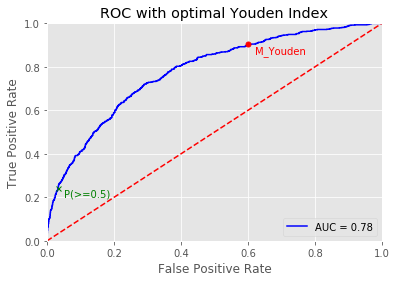


******* Using 0.5 Classification Threshold *******

[[2280   75]
 [ 566  179]]
the Accuracy is: 0.793
npv: 0.801
the classification_report:
               precision    recall  f1-score   support

         0.0      0.801     0.968     0.877      2355
         1.0      0.705     0.240     0.358       745

   micro avg      0.793     0.793     0.793      3100
   macro avg      0.753     0.604     0.618      3100
weighted avg      0.778     0.793     0.752      3100


******* Using Optimal Youden Classification Threshold *******


the Youden optimal index is : 0.136
[[ 939 1416]
 [  72  673]]
the Accuracy is: 0.520
npv: 0.929
the classification_report:
               precision    recall  f1-score   support

         0.0      0.929     0.399     0.558      2355
         1.0      0.322     0.903     0.475       745

   micro avg      0.520     0.520     0.520      3100
   macro avg      0.625     0.651     0.516      3100
weighted avg      0.783     0.520     0.538      3100



{'auc': 0.7775895923281895,
 'f1': 0.4749470712773465,
 'model': 'RandomForestClassifier',
 'npv': 0.9287833827893175,
 'precision': 0.3221637146960268,
 'recall': 0.9033557046979865}

time: 529 ms


In [9]:
save_boolean=False
classifier_eval(models_24_dic['rf'],x=x_test_24,y=y_test_24)

In [51]:
models_24_dic

{'knn': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
            metric_params=None, n_jobs=None, n_neighbors=25, p=1,
            weights='uniform'),
 'logreg': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='warn',
           n_jobs=None, penalty='l1', random_state=None, solver='warn',
           tol=0.0001, verbose=0, warm_start=False),
 'rf': RandomForestClassifier(bootstrap=False, class_weight=None,
             criterion='entropy', max_depth=25, max_features=10,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=2,
             min_samples_split=10, min_weight_fraction_leaf=0.0,
             n_estimators=200, n_jobs=None, oob_score=False,
             random_state=None, verbose=0, warm_start=False),
 'svc': SVC(C=10, cache_size=200, class_weight='balanced', coef0=0.0,
   decision_function_shape='ovr', 

time: 3.2 ms


In [330]:
def roc_publishing(model, x, y, proba_input=False,pos_label=1, print_default=True, model_name=None):
    import sklearn.metrics as metrics
    from sklearn.metrics import precision_score, roc_auc_score, f1_score, recall_score

    model_name=type(model).__name__

    y_pred = model.predict(x)
    y_proba = model.predict_proba(x)[:,1]
        
    fpr, tpr, thresholds = metrics.roc_curve(y, y_proba, pos_label=pos_label)
    roc_auc = metrics.auc(fpr, tpr)
    
    #gathering the optimal youden_index and df of tpr/fpr for auc and index of that optimal youden. idx is needed in the roc
    youden_threshold, roc_df, idx= optimal_youden_index(fpr, tpr, thresholds,tp90=True)
    
    return(fpr, tpr, roc_auc, roc_df, idx)

time: 14.7 ms


In [331]:
def stacked_roc(x_test, y_test, models_dic):
    plt.style.use('seaborn-white')
    plt.rcParams['figure.figsize'] = [7, 4]
    
    for model_name in models_dic.keys():
    
        model=models_dic[model_name]
        fpr, tpr, roc_auc, roc_df, idx= roc_publishing(model, x=np.array(x_test), y=y_test, model_name=model_name)
        ax1= plt.plot(fpr, tpr, 'b', label = '%s AUC = %0.3f' % (model_name, roc_auc), linewidth=2)
        og_idx=roc_df.iloc[(roc_df['thresholds']-0.5).abs().argsort()[:1]].index[0]
        plt.plot(roc_df.iloc[og_idx,1], roc_df.iloc[og_idx,2],marker='o', markersize=8, color="black")
        plt.plot(roc_df.iloc[idx,1], roc_df.iloc[idx,2],marker='o', markersize=6, color='r') ##

    plt.annotate(s="P(0.5)",xy=(0.78, 0.345),color='black', size=10) #textcoords
    plt.plot(0.73, 0.36, 'ro', color='black')
    plt.annotate(s="P(tuned)",xy=(0.78, 0.405),color='black', size=10) #textcoords
    plt.plot(0.73, 0.42, 'ro', color='r')

    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate', size=14)
    plt.xlabel('False Positive Rate', size=14)

    #saveplot(plt,'stacked_roc')

    plt.show()

time: 64.4 ms


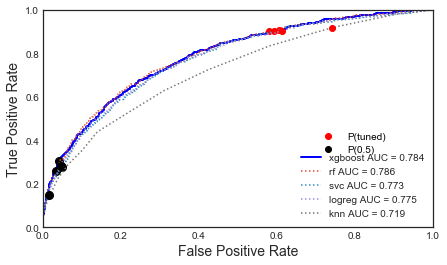

time: 5.1 s


In [62]:
stacked_roc(x_test_24, y_test_24, models_24_dic)

# Evaluating misclassified patients

In [332]:
def optimal_youden_index(fpr, tpr, thresholds, tp90=True):
    """
    inputs fpr, tpr, thresholds from metrics.roc(),
    outputs the clasification threshold, roc dataframe, and the index of roc dataframe for optimal youden index
    """
    #making dataframe out of the thresholds
    roc_df= pd.DataFrame({"thresholds": thresholds,"fpr":fpr, "tpr": tpr})
    roc_df.iloc[0,0] =1
    roc_df['yuden']= roc_df['tpr']-roc_df['fpr']
    
    if tp90==True:
        idx= roc_df[roc_df['tpr']>=0.9]['yuden'].idxmax() #changed this so now finds optimial yuden threshold but tp>=90%
    else:
        idx=roc_df['yuden'].idxmax() #MAX INDEX
    
    youden_threshold=roc_df.iloc[idx,0] #threshold for max youden
    return(youden_threshold, roc_df, idx)

time: 9.94 ms


In [333]:
def youden_predict(model, x, y, pos_label=1):
    import sklearn.metrics as metrics
    y_proba = model.predict_proba(x)[:,1]
    
    fpr, tpr, thresholds = metrics.roc_curve(y, y_proba, pos_label=pos_label)
    roc_auc = metrics.auc(fpr, tpr)
    
    #gathering the optimal youden_index and df of tpr/fpr for auc and index of that optimal youden. idx is needed in the roc
    youden_threshold, roc_df, idx= optimal_youden_index(fpr, tpr, thresholds,tp90=True)
    
    y_pred_youden = [np.array(1.) if y >= youden_threshold else np.array(0.) for y in y_proba]
    
    return(y_pred_youden, youden_threshold)

time: 36.8 ms


NameError: name 'youden_threshold' is not defined

time: 11.9 ms


In [156]:

foo_youden_pred, foo_youden_thresh=youden_predict(model=models_24_dic['rf'],x=x_test_24,y=y_test_24)

y_proba = model.predict_proba(x)[:,1]

time: 136 ms


In [35]:
models_24_dic.keys()

dict_keys(['rf', 'knn', 'logreg', 'xgboost', 'ensemble', 'svc'])

time: 2.3 ms


In [21]:
tn, fp, fn, tp =confusion_matrix(y_test_24, foo_youden_pred).ravel()#[0,0]/sum(np.array(foo_youden_pred)==0)

time: 6.94 ms


In [33]:
def tabulate_confusion(y_test, youden_pred):
    "returns all # of tn, fp, fn, tp for each model"
    tn, fp, fn, tp =confusion_matrix(y_test, youden_pred).ravel()
    return(tn, fp, fn, tp)

time: 1.73 ms


In [334]:
tn=[]
fp=[]
fn=[]
tp=[]

for key in models_24_dic.keys():
    youden_pred_24=youden_predict(model=models_24_dic[key],x=x_test_24,y=y_test_24)
    tabulate_confusion(

SyntaxError: unexpected EOF while parsing (<ipython-input-334-13a072e9f9a8>, line 8)

In [335]:
def tabulate_confusion_allmodel(model_dic, x_test, y_test):
    tn_list=[]
    fp_list=[]
    fn_list=[]
    tp_list=[]
    model=[]
    misclassified={}

    for key in model_dic.keys():
        print(key)
        youden_pred=youden_predict(model=model_dic[str(key)],x=np.array(x_test),y=y_test)
        tn, fp, fn, tp= tabulate_confusion(y_test, youden_pred)
        tn_list.append(tn)
        fp_list.append(fp)
        fn_list.append(fn)
        tp_list.append(tp)
        model.append(key)
        misclass= np.where(np.array(y_test).reshape(-1,) != np.asfarray(youden_pred).reshape(-1,))
        misclassified[str(key)]= np.array(misclass).reshape(-1)
    dic1={'model':model,
      'tn':tn_list,
      'fp':fp_list,
      'fn':fn_list,
      'tp':tp_list}
    
    return(pd.DataFrame(dic1),#.set_index('model'),
           misclassified)#, index=['rows'])

time: 26 ms


In [336]:
conf_24, misclassified_24= tabulate_confusion_allmodel(models_24_dic, x_test_24, y_test_24)

rf


ValueError: Found input variables with inconsistent numbers of samples: [3100, 2]

time: 181 ms


In [337]:
conf_24

,model,tn,fp,fn,tp
0,rf,939,1416,72,673
1,knn,490,1865,53,692
2,logreg,938,1417,73,672
3,xgboost,918,1437,73,672
4,ensemble,1028,1327,74,671
5,svc,971,1384,73,672


time: 9.76 ms


In [139]:
for key in misclassified_24.keys():
    print(misclassified_24[str(key)].shape)

(1488,)
(1918,)
(1490,)
(1510,)
(1401,)
(1457,)
time: 1.14 ms


In [ ]:
#positive= at or above threshold
#negative= below threshold
#false negative = 1 in y_true but <youden in pred. 
# y_pred_youden = [np.array(1.) if y >= youden_threshold else np.array(0.) for y in y_proba]
    

In [161]:
### now trying to identify the false negatives patients
## false positive= above the youden threshold 

#y_pred_youden = [np.array(1.) if y >= youden_threshold else np.array(0.) for y in y_proba]
    
foo_youden_pred, foo_youden_thresh=youden_predict(model=models_24_dic['rf'],x=x_test_24,y=y_test_24)

y_proba = models_24_dic['rf'].predict_proba(x_test_24)[:,1]


time: 257 ms


In [232]:
foo=np.where((y_proba< foo_youden_thresh) & (np.array(y_test_24['0'])==1.))[0]#.resize(-1)

time: 1.57 ms


In [241]:
foo2=(y_proba< foo_youden_thresh) & (np.array(y_test_24['0'])==1.)

time: 1.65 ms


In [245]:
sum(foo2)

72

time: 10.2 ms


In [233]:
foo  ###this is the row index of patients who are false positives

array([  66,  124,  127,  133,  185,  247,  266,  292,  393,  465,  505,
        506,  521,  533,  575,  620,  807,  820,  871,  931, 1041, 1047,
       1072, 1134, 1140, 1177, 1187, 1431, 1463, 1502, 1509, 1577, 1593,
       1607, 1639, 1667, 1678, 1683, 1707, 1788, 1827, 1849, 1883, 1910,
       1961, 1971, 2034, 2081, 2092, 2155, 2183, 2200, 2239, 2312, 2356,
       2395, 2498, 2502, 2508, 2519, 2520, 2556, 2575, 2594, 2641, 2650,
       2683, 2812, 2826, 2828, 2920, 3018])

time: 2.27 ms


In [256]:
####
fp_rf_foo= x_test.loc[foo2,:].describe()
notfp_rf_foo=x_test.loc[~foo2,:].describe()

time: 130 ms


In [269]:
fp_rf_foo.iloc[1:,]

,bilirubin,bun,chloride,creatinine,glucose,heartrate,inr,lactate,o2_flow,potassium,...,"pao2fio2ratio_(475, 3000]",vent_recieved_2.0,dobutamine_1.0,dopamine_1.0,epinephrine_1.0,norepinephrine_1.0,phenylephrine_1.0,rrt_1.0,vasopressin_1.0,cancer_elix_1.0
mean,-0.021278,-0.062198,-0.005024,-0.027823,0.043382,0.032717,-0.011719,0.068797,0.0,0.042092,...,0.972222,0.263889,0.0,0.0,0.013889,0.013889,0.041667,0.069444,0.0,0.097222
std,0.257121,0.183826,0.025439,0.580117,0.079913,0.056355,0.264071,0.238737,0.0,0.212038,...,0.165489,0.443833,0.0,0.0,0.117851,0.117851,0.201229,0.255992,0.0,0.298339
min,-0.442507,-0.556641,-0.094174,-0.807355,-0.130336,-0.081151,-0.567819,-0.544577,0.0,-0.417952,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,-0.078921,-0.173204,-0.017340,-0.392317,-0.014182,-0.014622,-0.166676,0.075296,0.0,-0.102653,...,1.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
50%,0.000000,-0.089373,-0.004273,-0.222392,0.043605,0.033802,0.000000,0.075296,0.0,0.030253,...,1.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
75%,0.000000,0.061424,0.012585,0.131245,0.093771,0.076382,0.126488,0.075296,0.0,0.117640,...,1.000000,1.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
max,1.114986,0.370127,0.044536,2.050626,0.232808,0.158697,0.789673,0.867552,0.0,0.867504,...,1.000000,1.000000,0.0,0.0,1.000000,1.000000,1.000000,1.000000,0.0,1.000000


time: 20.1 ms


In [268]:
notfp_rf_foo.iloc[1:,]

,bilirubin,bun,chloride,creatinine,glucose,heartrate,inr,lactate,o2_flow,potassium,...,"pao2fio2ratio_(475, 3000]",vent_recieved_2.0,dobutamine_1.0,dopamine_1.0,epinephrine_1.0,norepinephrine_1.0,phenylephrine_1.0,rrt_1.0,vasopressin_1.0,cancer_elix_1.0
mean,0.106268,0.015781,0.000209,0.184392,0.054587,0.052691,0.300170,0.119943,0.027411,0.076246,...,0.758587,0.441215,0.008587,0.045905,0.027741,0.142008,0.137715,0.066380,0.018164,0.116248
std,0.505814,0.209192,0.028068,0.643933,0.095578,0.062085,0.772834,0.374988,0.163304,0.216457,...,0.428011,0.496614,0.092280,0.209313,0.164257,0.349116,0.344657,0.248987,0.133566,0.320575
min,-0.537467,-0.646015,-0.132350,-0.932886,-0.194416,-0.218930,-0.567819,-0.681175,0.000000,-0.726162,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,-0.125965,-0.017340,-0.222392,-0.013205,0.010532,-0.132111,0.038297,0.000000,-0.062328,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.045141,0.055449,0.126488,0.075296,0.000000,0.059930,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.158697,0.016704,0.415037,0.106861,0.094684,0.364376,0.075296,0.000000,0.200384,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3.679094,0.702116,0.122342,3.777608,0.492241,0.293810,6.944931,2.485311,1.000000,1.154473,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


time: 22.8 ms


In [264]:
#fp_rf_foo.loc['mean',:]#[0]#[''- notfp_rf_foo
abs(fp_rf_foo- notfp_rf_foo).loc['mean',:].sort_values(ascending=False)

inr                            0.311888
weight                         0.267910
any_vasoactives_1.0            0.220865
pao2fio2ratio_(475, 3000]      0.213636
creatinine                     0.212215
vent_recieved_2.0              0.177326
gender                         0.167712
yearsold                       0.136667
norepinephrine_1.0             0.128119
bilirubin                      0.127546
phenylephrine_1.0              0.096048
sum_elix                       0.091421
bun                            0.077979
pao2fio2ratio_(200, 333]       0.072985
pao2fio2ratio_(333, 475]       0.063702
leukocyte_1.0                  0.063683
ipco2_>50                      0.057427
ptt                            0.056619
ibands_absent                  0.052106
lactate                        0.051145
resprate                       0.049532
dopamine_1.0                   0.045905
bicarbonate                    0.036022
potassium                      0.034155
meanartpress                   0.030888


time: 7.34 ms


In [ ]:
#### more formally looking at t-test for all variable distributions

In [305]:
#### more formally looking at t-test for all variable distributions
from scipy import stats

samp_fp= x_test.loc[foo2,'bilirubin'].tolist()
samp_nonfp= x_test.loc[~foo2,'bilirubin'].tolist() #using 0 as a test
stats.ttest_ind(samp_fp,samp_nonfp)

Ttest_indResult(statistic=-2.1328551535945928, pvalue=0.03301500361940335)

time: 5.77 ms


In [285]:
t_list=[]
p_list=[]
for element in list(x_test):
    samp_fp= x_test.loc[foo2,element].tolist()
    samp_nonfp= x_test.loc[~foo2,element].tolist() #using 0 as a test
    t2, p2 = stats.ttest_ind(samp_fp,samp_nonfp)
    p_list.append(p2)
    t_list.append(t2)

time: 70.9 ms


In [287]:
pd.DataFrame(p_list).describe()

,0
count,5.300000e+01
mean,2.356885e-01
std,2.837145e-01
min,5.748982e-07
25%,6.898965e-03
50%,1.172491e-01
75%,4.299277e-01
max,9.178654e-01


time: 12.3 ms


In [292]:
sum(np.array(p_list)<=0.05)

20

time: 2.47 ms


In [297]:
list(np.array(p_list)<=0.05)

[True,
 True,
 False,
 True,
 False,
 True,
 True,
 False,
 False,
 False,
 True,
 True,
 False,
 True,
 True,
 True,
 False,
 True,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 True,
 False,
 True,
 True,
 False,
 False,
 False,
 True,
 True,
 False,
 False,
 False]

time: 3.04 ms


In [304]:
np.array(p_list)

array([3.30150036e-02, 1.73906871e-03, 1.17249107e-01, 5.64358025e-03,
       3.23930869e-01, 6.89896540e-03, 6.36312748e-04, 2.49540925e-01,
       1.54535304e-01, 1.85643487e-01, 7.28005309e-04, 8.93949000e-05,
       1.98901636e-01, 5.74898231e-07, 1.10120610e-02, 1.58412381e-02,
       8.20314098e-02, 2.01279858e-02, 2.31290043e-01, 1.35459791e-01,
       1.80430560e-01, 1.76802320e-01, 3.08693949e-04, 6.72645221e-01,
       2.25713671e-01, 4.51170497e-01, 8.64037454e-01, 9.03779340e-01,
       2.02416636e-03, 6.00982748e-03, 7.41666235e-02, 6.50578869e-01,
       7.79746300e-01, 6.40201660e-01, 6.37554505e-01, 5.27630776e-01,
       1.56632311e-01, 8.23688818e-02, 3.04691206e-05, 8.00826188e-02,
       7.48124536e-01, 1.73665989e-02, 6.19764617e-02, 2.43416331e-05,
       2.70899970e-03, 4.29927712e-01, 6.28912958e-02, 4.77019891e-01,
       1.89236433e-03, 1.85905443e-02, 9.17865370e-01, 2.48693547e-01,
       6.18178557e-01])

time: 3.08 ms


In [302]:
fp_rf_foo.iloc[1:, list(np.array(p_list)<=0.05)]

,bilirubin,bun,creatinine,heartrate,inr,ptt,resprate,temperature,bicarbonate,diasbp,meanartpress,sysbp,gender,weight,any_vasoactives_1.0,"pao2fio2ratio_(200, 333]","pao2fio2ratio_(475, 3000]",vent_recieved_2.0,norepinephrine_1.0,phenylephrine_1.0
mean,-0.021278,-0.062198,-0.027823,0.032717,-0.011719,-0.016203,0.114414,0.006302,0.005954,-0.084601,-0.068954,-0.044770,0.541667,-0.262470,0.055556,0.0,0.972222,0.263889,0.013889,0.041667
std,0.257121,0.183826,0.580117,0.056355,0.264071,0.097812,0.090104,0.029920,0.084192,0.078488,0.067403,0.041641,0.501757,0.732881,0.230669,0.0,0.165489,0.443833,0.117851,0.201229
min,-0.442507,-0.556641,-0.807355,-0.081151,-0.567819,-0.159352,-0.107309,-0.141004,-0.229346,-0.271192,-0.288743,-0.121780,0.000000,-2.265183,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
25%,-0.078921,-0.173204,-0.392317,-0.014622,-0.166676,-0.063297,0.067211,-0.008366,-0.048561,-0.115141,-0.101939,-0.075355,0.000000,-0.774995,0.000000,0.0,1.000000,0.000000,0.000000,0.000000
50%,0.000000,-0.089373,-0.222392,0.033802,0.000000,-0.003205,0.107309,0.007826,0.000000,-0.075785,-0.067068,-0.050047,1.000000,-0.253218,0.000000,0.0,1.000000,0.000000,0.000000,0.000000
75%,0.000000,0.061424,0.131245,0.076382,0.126488,0.002104,0.161809,0.023343,0.062748,-0.040544,-0.022728,-0.026747,1.000000,0.049602,0.000000,0.0,1.000000,1.000000,0.000000,0.000000
max,1.114986,0.370127,2.050626,0.158697,0.789673,0.450373,0.308666,0.065109,0.215175,0.066605,0.063776,0.072181,1.000000,1.775344,1.000000,0.0,1.000000,1.000000,1.000000,1.000000


time: 20 ms


In [303]:
notfp_rf_foo.iloc[1:, list(np.array(p_list)<=0.05)]

,bilirubin,bun,creatinine,heartrate,inr,ptt,resprate,temperature,bicarbonate,diasbp,meanartpress,sysbp,gender,weight,any_vasoactives_1.0,"pao2fio2ratio_(200, 333]","pao2fio2ratio_(475, 3000]",vent_recieved_2.0,norepinephrine_1.0,phenylephrine_1.0
mean,0.106268,0.015781,0.184392,0.052691,0.300170,0.040416,0.163947,0.024292,-0.030068,-0.110722,-0.099842,-0.068524,0.709379,0.005440,0.276420,0.072985,0.758587,0.441215,0.142008,0.137715
std,0.505814,0.209192,0.643933,0.062085,0.772834,0.141232,0.106230,0.030118,0.119442,0.091018,0.112230,0.055430,0.454124,0.819126,0.447301,0.260156,0.428011,0.496614,0.349116,0.344657
min,-0.537467,-0.646015,-0.932886,-0.218930,-0.567819,-0.199282,-0.207163,-0.144935,-0.827087,-0.448899,-1.256928,-0.303234,0.000000,-11.146106,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,-0.125965,-0.222392,0.010532,-0.132111,-0.037798,0.087678,0.003919,-0.089600,-0.155126,-0.126677,-0.099439,0.000000,-0.479824,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.055449,0.126488,0.002104,0.161809,0.019481,-0.020978,-0.105336,-0.084519,-0.065607,1.000000,-0.019188,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,0.158697,0.415037,0.094684,0.364376,0.062120,0.226024,0.044389,0.039550,-0.048600,-0.047093,-0.035270,1.000000,0.440699,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000
max,3.679094,0.702116,3.777608,0.293810,6.944931,0.535473,0.602452,0.141044,0.366384,0.176868,0.135348,0.109685,1.000000,3.433836,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


time: 19.5 ms


In [306]:
fp_rf_foo

,bilirubin,bun,chloride,creatinine,glucose,heartrate,inr,lactate,o2_flow,potassium,...,"pao2fio2ratio_(475, 3000]",vent_recieved_2.0,dobutamine_1.0,dopamine_1.0,epinephrine_1.0,norepinephrine_1.0,phenylephrine_1.0,rrt_1.0,vasopressin_1.0,cancer_elix_1.0
count,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.0,72.000000,...,72.000000,72.000000,72.0,72.0,72.000000,72.000000,72.000000,72.000000,72.0,72.000000
mean,-0.021278,-0.062198,-0.005024,-0.027823,0.043382,0.032717,-0.011719,0.068797,0.0,0.042092,...,0.972222,0.263889,0.0,0.0,0.013889,0.013889,0.041667,0.069444,0.0,0.097222
std,0.257121,0.183826,0.025439,0.580117,0.079913,0.056355,0.264071,0.238737,0.0,0.212038,...,0.165489,0.443833,0.0,0.0,0.117851,0.117851,0.201229,0.255992,0.0,0.298339
min,-0.442507,-0.556641,-0.094174,-0.807355,-0.130336,-0.081151,-0.567819,-0.544577,0.0,-0.417952,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,-0.078921,-0.173204,-0.017340,-0.392317,-0.014182,-0.014622,-0.166676,0.075296,0.0,-0.102653,...,1.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
50%,0.000000,-0.089373,-0.004273,-0.222392,0.043605,0.033802,0.000000,0.075296,0.0,0.030253,...,1.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
75%,0.000000,0.061424,0.012585,0.131245,0.093771,0.076382,0.126488,0.075296,0.0,0.117640,...,1.000000,1.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
max,1.114986,0.370127,0.044536,2.050626,0.232808,0.158697,0.789673,0.867552,0.0,0.867504,...,1.000000,1.000000,0.0,0.0,1.000000,1.000000,1.000000,1.000000,0.0,1.000000


time: 25.2 ms


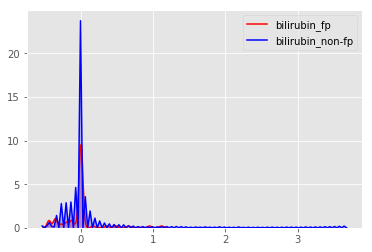

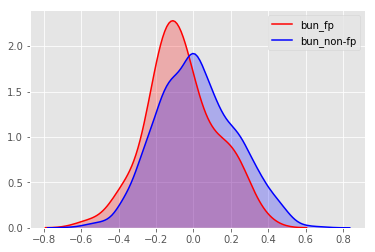

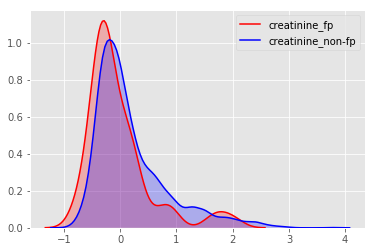

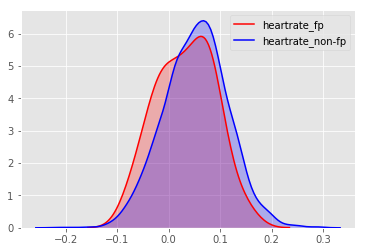

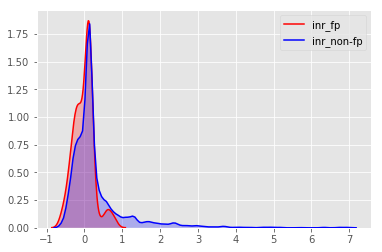

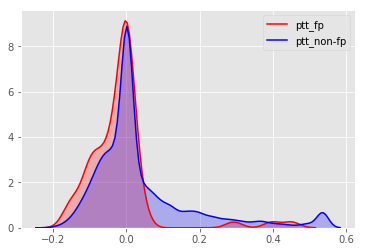

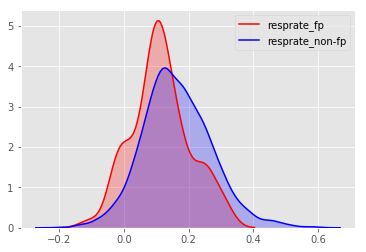

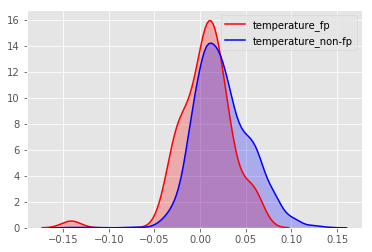

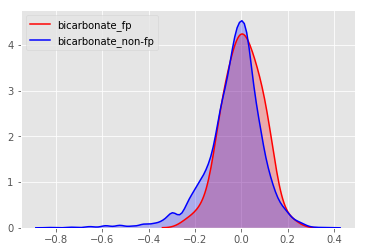

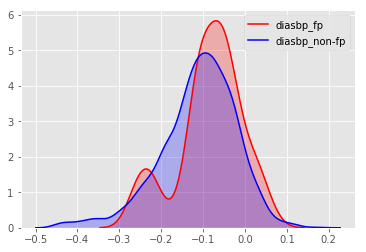

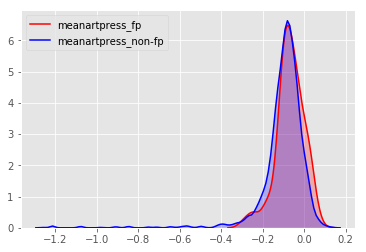

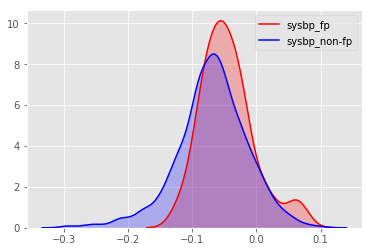

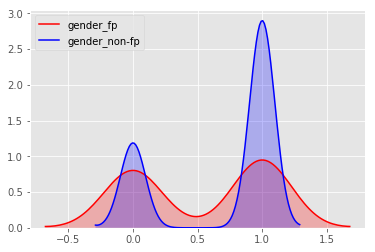

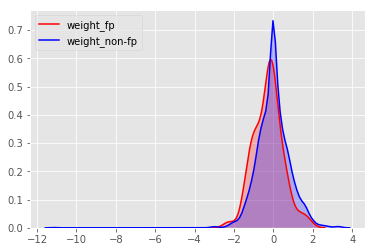

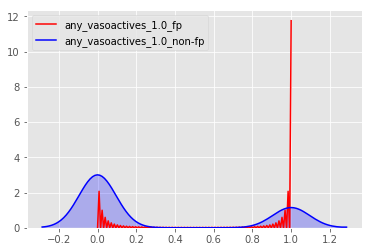

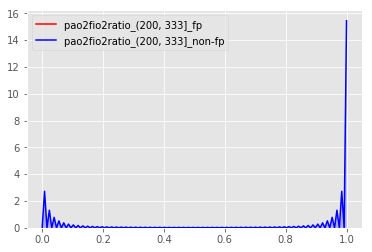

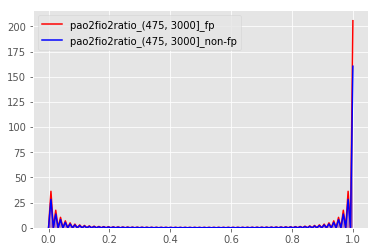

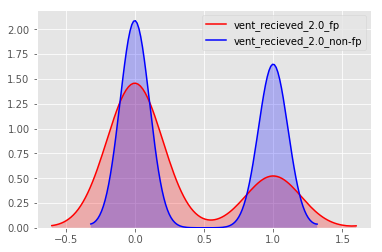

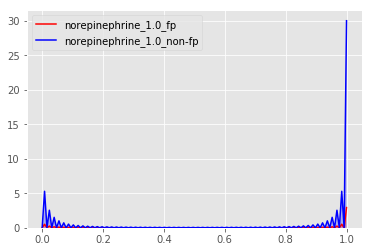

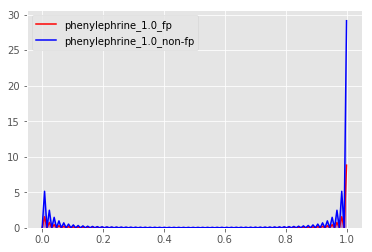

time: 3.19 s


In [314]:
####
# fp_rf_foo= x_test.loc[foo2,:].describe()
# notfp_rf_foo=x_test.loc[~foo2,:].describe()
# x_test.loc[foo2,'bilirubin']
# x_test.loc[~foo2,'bilirubin']

sig_vars=list(fp_rf_foo.iloc[1:, list(np.array(p_list)<=0.05)])

# library and dataset
import seaborn as sns
import matplotlib.pyplot as plt
#import 

for element in sig_vars:
    p1=sns.kdeplot(x_test.loc[foo2,element], shade=True, color="r",label="{}_fp".format(element))
    p1=sns.kdeplot(x_test.loc[~foo2,element], shade=True, color="b",label="{}_non-fp".format(element))
    plt.show()
# plot of 2 variables
# p1=sns.kdeplot(x_test.loc[foo2,'bilirubin'], shade=True, color="r",label="{}_fp".format('bilirubin'))
# p1=sns.kdeplot(x_test.loc[~foo2,'bilirubin'], shade=True, color="b",label="{}_non-fp".format('bilirubin'))
#sns.plt.show()


### note from nelson:
100% focus should be on FN. Your goal is to minimize those patients, as those are the ones that could get you in trouble if you recommended stopping antibiotics. When you look at those, one interesting thing to look at will be their outcomes, meaning, are the FN outcomes more like the TN ones or the TP ones? This will answer the question: if you miss a FN is it a big deal (because their outcomes are as bad as the TP) or is it not as problematic because their outcomes are relatively good in general, so even stopping antibiotics early might not impact things too much… Hopefully that makes sense

(array([  66,  124,  127,  133,  185,  247,  266,  292,  393,  465,  505,
         506,  521,  533,  575,  620,  807,  820,  871,  931, 1041, 1047,
        1072, 1134, 1140, 1177, 1187, 1431, 1463, 1502, 1509, 1577, 1593,
        1607, 1639, 1667, 1678, 1683, 1707, 1788, 1827, 1849, 1883, 1910,
        1961, 1971, 2034, 2081, 2092, 2155, 2183, 2200, 2239, 2312, 2356,
        2395, 2498, 2502, 2508, 2519, 2520, 2556, 2575, 2594, 2641, 2650,
        2683, 2812, 2826, 2828, 2920, 3018]),)

time: 2.19 ms


### variable importance:

In [361]:
# def var_imp(model,model_name, timewindow, x_train, n_var=4):
#     model_name=type(model).__name__
#     plot_title= "Top {} {} {} Variable Importance".format(n_var, timewindow,model_name)
#     feat_importances = pd.Series(model.feature_importances_, index=x_train.columns)
#     topn=feat_importances.nlargest(n_var).sort_values()
#     return(topn)

def var_imp(model, x_train, n_var=4):
    model_name=type(model).__name__
    #plot_title= "Top {} {} {} Variable Importance".format(n_var, timewindow,model_name)
    feat_importances = pd.Series(model.feature_importances_, index=x_train.columns)
    topn=feat_importances.nlargest(n_var).sort_values()
    return(topn)

#log reg important features

def coef_feature_importance(model, x_train):
    feature_importance = abs(model.coef_[0])
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)[-10:]#[0]
    pos = np.arange(sorted_idx.shape[0]) + .5

    features,top10 =list(np.array(x_train.columns)[sorted_idx][-10:]), feature_importance[sorted_idx]
    return(features, top10)

time: 13.6 ms


In [429]:
models_dic= models_24_dic
x_train=x_train_24

features_dic={}
top_set_dic={}

n_var=10

for model_name in models_dic.keys():
    model= models_dic[model_name]
    if model_name in ['knn','ensemble']:
        pass
    elif model_name in ['logreg','svc']:
        feature_importance = abs(model.coef_[0])
        sorted_idx = np.argsort(feature_importance)[-n_var:]#[0]
        features =list(np.array(x_train.columns)[sorted_idx][-n_var:])
        features_dic.update( {model_name :features } )
        
    else:
        features=var_imp(model, x_train, n_var=n_var)
        features=list(features.reset_index()['index'])
        features_dic.update( {model_name :features } )

#######
set_features=[]

for features in features_dic.values():
    set_features=set_features+features
set_features=set(set_features)
varimp_names=list(set_features)
#varimp_names

['temperature',
 'maxSodium',
 'bicarbonate',
 'spo2',
 'sysbp',
 'pao2fio2ratio_(475, 3000]',
 'bun',
 'norepinephrine_1.0',
 'platelet',
 'leukocyte_1.0',
 'ibands_absent',
 'glucose',
 'chloride',
 'minSodium',
 'resprate',
 'nitrite_1.0',
 'hemoglobin',
 'minWBC',
 'epinephrine_1.0',
 'vasopressin_1.0',
 'heartrate']

time: 52.2 ms


In [430]:
#getting index of the set(top10) variables in x_train
xtrain_column_index_list=[]
for element in varimp_names:
    variable_index=list(x_train).index(element)
    xtrain_column_index_list.append(variable_index)


time: 2.94 ms


In [454]:
top_set_dic={}

#getting index of the set(top10) variables in x_train
xtrain_column_index_list=[]
for element in varimp_names:
    variable_index=list(x_train).index(element)
    xtrain_column_index_list.append(variable_index)


for model_name in models_dic.keys(): ##now that we have set of top N variables for each model. we can make relative importance for all unique variables in the set
    model= models_dic[model_name]
    if model_name in ['knn','ensemble']:
        pass
    elif model_name in ['logreg','svc']:
        imp= abs(model.coef_[0])[xtrain_column_index_list]
        rel_imp=100.0 * (imp / imp.max())
        features =list(np.array(x_train.columns)[xtrain_column_index_list])#[-n_var:])
        top_set= pd.Series(rel_imp,features).sort_values()
        top_set_dic.update( {model_name :top_set } )
        
    else:
        imp=pd.Series(models_24_dic[model_name].feature_importances_, index=x_train.columns)[xtrain_column_index_list]
        imp=imp.sort_values()
        rel_imp=100.0 * (imp / imp.max())
        features =list(np.array(x_train.columns)[xtrain_column_index_list])
        top_set= rel_imp
        top_set_dic.update( {model_name :top_set } )
    

time: 76.7 ms


In [434]:
top_set_dic

{'logreg': maxSodium                      0.000000
 minSodium                      0.000000
 chloride                       0.000000
 platelet                       0.000000
 glucose                        0.285890
 minWBC                         1.472460
 hemoglobin                     3.963781
 ibands_absent                  4.080384
 pao2fio2ratio_(475, 3000]      4.577936
 leukocyte_1.0                  5.585511
 bicarbonate                    6.940209
 spo2                           7.006959
 nitrite_1.0                    7.313703
 vasopressin_1.0                8.150204
 norepinephrine_1.0             9.701868
 epinephrine_1.0               11.900351
 resprate                      20.242377
 bun                           21.793059
 sysbp                         22.979157
 heartrate                     25.169944
 temperature                  100.000000
 dtype: float64, 'rf': vasopressin_1.0                1.800108
 epinephrine_1.0                2.248060
 nitrite_1.0             

time: 5.07 ms


In [ ]:
def roc_name_adjust(varimp_names):
    """
    cleans up the column names for the variable importance plot for publishing
    """
    adjusted_names=[]
    mapper={'vent_recieved_2.0': 'mechanical ventilation recieved',
            'vent_recieved_1.0': 'oxygen ventilation recieved',
            'vent_recieved_1.0': 'no ventilation recieved',
            'pao2fio2ratio_(475, 3000]': 'PaO2:FiO2 (475-3000)',
            'pao2fio2ratio_(200, 333]': 'PaO2:FiO2 (200-333)',
            'pao2fio2ratio_(333, 475]': 'PaO2:FiO2 (333-475)',
            'ipco2_>50': 'pCO2 (>50)',
            'ibands_>10': 'bands (>10)',
            'ibands_absent': 'bands (missing)'}
    
    for element in varimp_names:
        if element in mapper.keys():
            element= mapper[element]
            adjusted_names.append(element)
        elif "_1.0" in element:
            element= element.strip("_1.0") + ' (Y/N)'
            adjusted_names.append(element)
        else:
            adjusted_names.append(element)
        
    return(adjusted_names)

In [ ]:
def stacked_varimp(top_10_dic,features_dic):
    """
    gets a stacked RELATIVE variable importance plot for all 4 classifiers for a given model dictionary (timewindow)
    """
    set_features=[]
    
    for features in features_dic.values():
        set_features=set_features+features
    set_features=set(set_features)
    varimp_names=list(set_features)
    
    df_base=pd.DataFrame(index=set_features)
    
    for model_name in top_10_dic.keys():
        df_base[model_name]= top_10_dic[model_name]
                
    adjusted_names= roc_name_adjust(varimp_names)
    
    df_base.index=adjusted_names
    df_base.sort_values('xgboost', ascending=False)
    
    plt.style.use('seaborn-ticks')
    plt.rcParams['figure.figsize'] = [7, 7]
    ax = df_base.sort_values('xgboost', ascending=False).plot.barh(stacked=True,
                                                               grid=False,
                                                               color=['r',(0.31,0.50,0.74),(0.35,0.35,0.40),(0.44,0.19,0.63)])#facecolor='w')#rot=0) #(0.96,0.59,0.27)
    ax.set_facecolor('w')
    ax.set_xlabel("Relative Variable Importance")
    return(df_base)

In [455]:
# features_dic_24, top_10_dic_24= model_var_imp(models_24_dic, '24_hr_window', x_train_24)
features_dic_24, top_10_dic_24= model_var_imp(top_set_dic, x_train_24)
df_base= stacked_varimp(top_10_dic_24, features_dic_24)

AttributeError: 'Series' object has no attribute 'feature_importances_'

time: 37.9 ms


Text(0.5, 0, 'Relative Variable Importance')

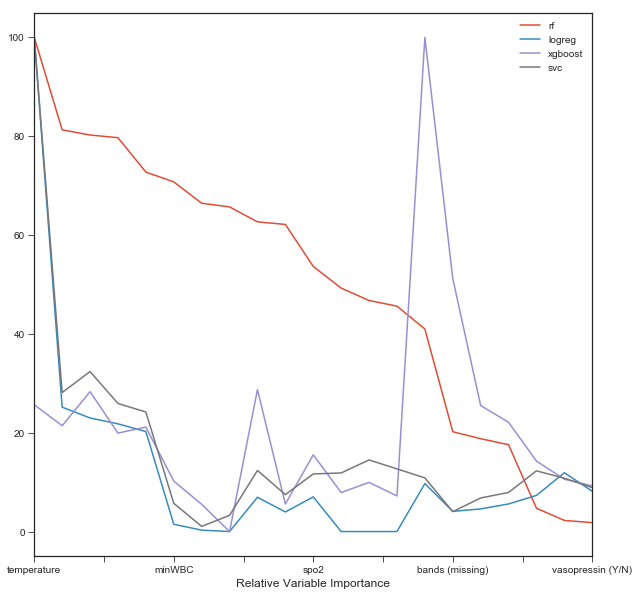

time: 270 ms


In [458]:
#features

df_base=pd.DataFrame(index=features)  

for model_name in top_set_dic.keys():
    df_base[model_name]= top_set_dic[model_name]
    
adjusted_names=roc_name_adjust(features)
df_base.index=adjusted_names
df_base.sort_values('rf', ascending=False)

plt.style.use('seaborn-ticks')
plt.rcParams['figure.figsize'] = [10,10]#[7, 7]

ax = df_base.sort_values('rf', ascending=False).plot.line(stacked=False,
                                                           grid=False)#,
                                                           #color=['r',(0.31,0.50,0.74),(0.35,0.35,0.40),(0.44,0.19,0.63)])#facecolor='w')#rot=0) #(0.96,0.59,0.27)
ax.set_facecolor('w')
ax.set_xlabel("Relative Variable Importance")

[Text(0, 0, 'temperature'),
 Text(0, 0, 'maxSodium'),
 Text(0, 0, 'bicarbonate'),
 Text(0, 0, 'spo2'),
 Text(0, 0, 'sysbp'),
 Text(0, 0, 'PaO2:FiO2 (475-3000)'),
 Text(0, 0, 'bun'),
 Text(0, 0, 'norepinephrine (Y/N)'),
 Text(0, 0, 'platelet')]

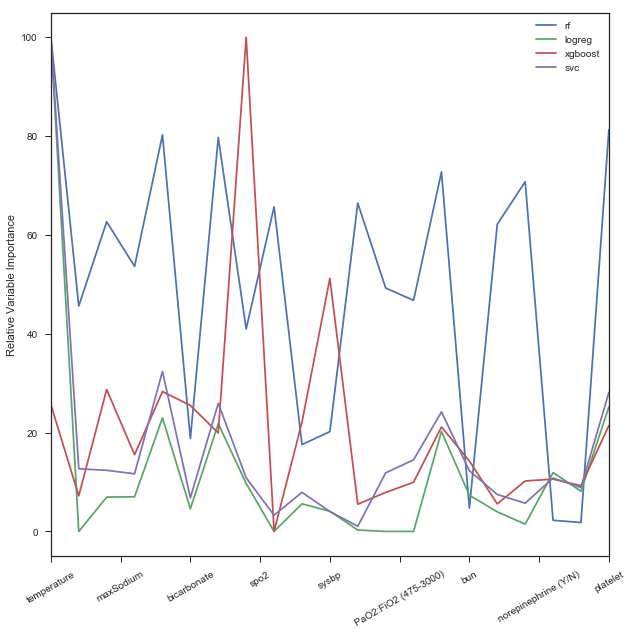

time: 261 ms


In [482]:
#['dummy']=0
#del df_base['dummy']
plt.style.use('seaborn-ticks')
plt.rcParams['figure.figsize'] = [10,10]#[7, 7]
ax = df_base.plot.line()
ax.set_ylabel("Relative Variable Importance")
ax.set_xticklabels(adjusted_names,rotation=30)
#ax.set_xticklabels(adjusted_names)#,rotation=30)

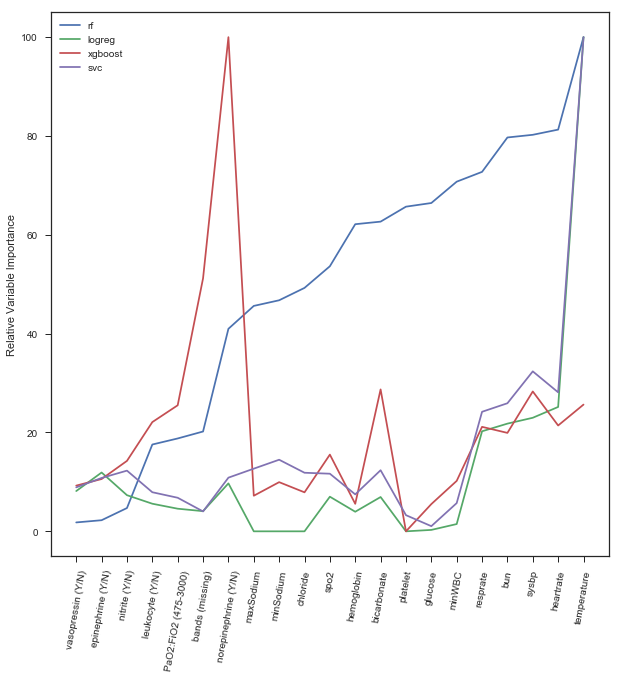

time: 305 ms


In [503]:
plt.style.use('seaborn-ticks')
plt.rcParams['figure.figsize'] = [10,10]#[7, 7]
plt.plot(df_base.sort_values('rf', ascending=True))
#plt.set_xticklabels(adjusted_names,rotation=30)
plt.xticks(rotation=80)#, ha='right')
plt.ylabel("Relative Variable Importance")
plt.legend(list(df_base))

In [457]:
top_set_dic

{'logreg': maxSodium                      0.000000
 minSodium                      0.000000
 chloride                       0.000000
 platelet                       0.000000
 glucose                        0.285890
 minWBC                         1.472460
 hemoglobin                     3.963781
 ibands_absent                  4.080384
 pao2fio2ratio_(475, 3000]      4.577936
 leukocyte_1.0                  5.585511
 bicarbonate                    6.940209
 spo2                           7.006959
 nitrite_1.0                    7.313703
 vasopressin_1.0                8.150204
 norepinephrine_1.0             9.701868
 epinephrine_1.0               11.900351
 resprate                      20.242377
 bun                           21.793059
 sysbp                         22.979157
 heartrate                     25.169944
 temperature                  100.000000
 dtype: float64, 'rf': vasopressin_1.0                1.800108
 epinephrine_1.0                2.248060
 nitrite_1.0             

time: 4.76 ms


In [445]:
roc_name_adjust(features)

['temperature',
 'maxSodium',
 'bicarbonate',
 'spo2',
 'sysbp',
 'PaO2:FiO2 (475-3000)',
 'bun',
 'norepinephrine (Y/N)',
 'platelet',
 'leukocyte (Y/N)',
 'bands (missing)',
 'glucose',
 'chloride',
 'minSodium',
 'resprate',
 'nitrite (Y/N)',
 'hemoglobin',
 'minWBC',
 'epinephrine (Y/N)',
 'vasopressin (Y/N)',
 'heartrate']

time: 2.19 ms


In [ ]:
# #list of variable importances for svc
# svc_imp= abs(models_24_dic['svc'].coef_[0])[xtrain_column_index_list]
# rel_imp=100.0 * (svc_imp / svc_imp.max())
# features =list(np.array(x_train.columns)[xtrain_column_index_list])#[-n_var:])

# pd.Series(rel_imp,features).sort_values()

In [431]:
# #list of variable importances for rf
# fi=pd.Series(models_24_dic['rf'].feature_importances_, index=x_train.columns)[xtrain_column_index_list]
# topn=fi.sort_values()
# rel_imp=100.0 * (topn / topn.max())
# #topn=feat_importances.nlargest(n_var).sort_values()

time: 20.6 ms


In [389]:
# models_dic= models_24_dic
# x_train=x_train_24

# features_dic={}
# top_10_dic={}

# n_var=10

# for model_name in models_dic.keys():
#     model= models_dic[model_name]
#     if model_name in ['knn','ensemble']:
#         pass
#     elif model_name in ['logreg','svc']:
#         feature_importance = abs(model.coef_[0])
#         feature_importance = 100.0 * (feature_importance / feature_importance.max())
#         sorted_idx = np.argsort(feature_importance)[-n_var:]#[0]
#         pos = np.arange(sorted_idx.shape[0]) + .5

#         features =list(np.array(x_train.columns)[sorted_idx][-n_var:])
#         features_dic.update( {model_name :features } )
        
#     else:
#         features=var_imp(model, x_train, n_var=n_var)
#         top10=(features/features[-1])*100
#         features=list(features.reset_index()['index'])
#         features_dic.update( {model_name :features } )

# #######
# set_features=[]

# for features in features_dic.values():
#     set_features=set_features+features
# set_features=set(set_features)
# varimp_names=list(set_features)
# varimp_names



['temperature',
 'maxSodium',
 'bicarbonate',
 'spo2',
 'sysbp',
 'pao2fio2ratio_(475, 3000]',
 'bun',
 'norepinephrine_1.0',
 'platelet',
 'leukocyte_1.0',
 'ibands_absent',
 'glucose',
 'chloride',
 'minSodium',
 'resprate',
 'nitrite_1.0',
 'hemoglobin',
 'minWBC',
 'epinephrine_1.0',
 'vasopressin_1.0',
 'heartrate']

time: 135 ms


In [397]:
# xtrain_column_index_list=[]
# for element in varimp_names:
#     variable_index=list(x_train).index(element)
#     xtrain_column_index_list.append(variable_index)

# #models_24_dic['logreg'].coef_[0]

time: 2.68 ms


In [428]:
# #list of variable importances for svc
# svc_imp= abs(models_24_dic['svc'].coef_[0])[xtrain_column_index_list]
# rel_imp=100.0 * (svc_imp / svc_imp.max())
# features =list(np.array(x_train.columns)[xtrain_column_index_list])#[-n_var:])

# pd.Series(rel_imp,features).sort_values()

glucose                        1.044325
platelet                       3.271289
ibands_absent                  4.027220
minWBC                         5.711475
pao2fio2ratio_(475, 3000]      6.793220
hemoglobin                     7.475689
leukocyte_1.0                  7.910410
vasopressin_1.0                8.898048
epinephrine_1.0               10.798149
norepinephrine_1.0            10.859831
spo2                          11.659259
chloride                      11.853476
nitrite_1.0                   12.280672
bicarbonate                   12.363985
maxSodium                     12.680348
minSodium                     14.488637
resprate                      24.187938
bun                           25.917657
heartrate                     28.126466
sysbp                         32.369085
temperature                  100.000000
dtype: float64

time: 7.61 ms


In [408]:
# fi=pd.Series(models_24_dic['rf'].feature_importances_, index=x_train.columns)[xtrain_column_index_list]
# topn=fi.sort_values()
# rel_imp=100.0 * (topn / topn.max())
# #topn=feat_importances.nlargest(n_var).sort_values()
# 100.0 * (topn / topn.max())

time: 18.8 ms


In [ ]:
models_dic= models_24_dic
x_train=x_train_24

features_dic={}
top_10_dic={}

n_var=10

for model_name in models_dic.keys():
    model= models_dic[model_name]
    if model_name in ['knn','ensemble']:
        pass
    elif model_name in ['logreg','svc']:
        feature_importance = abs(model.coef_[0])
        feature_importance = 100.0 * (feature_importance / feature_importance.max())
        sorted_idx = np.argsort(feature_importance)[-n_var:]#[0]
        pos = np.arange(sorted_idx.shape[0]) + .5

        features =list(np.array(x_train.columns)[sorted_idx][-n_var:])
        features_dic.update( {model_name :features } )
        
    else:
        features=var_imp(model, x_train, n_var=n_var)
        top10=(features/features[-1])*100
        features=list(features.reset_index()['index'])
        features_dic.update( {model_name :features } )

#######
set_features=[]

for features in features_dic.values():
    set_features=set_features+features
set_features=set(set_features)
varimp_names=list(set_features)
varimp_names

varimp_names

In [390]:
len(varimp_names)

21

time: 1.81 ms


In [375]:

def coef_feature_importance(model, x_train, n_var=10):
    model_name=type(model).__name__
    
    if model_name in ['LogisticRegression','SVC']:
        feature_importance = abs(model.coef_[0])
        feature_importance = 100.0 * (feature_importance / feature_importance.max())
        sorted_idx = np.argsort(feature_importance)[-n_var:]#[0]
        pos = np.arange(sorted_idx.shape[0]) + .5

        features =list(np.array(x_train.columns)[sorted_idx][-n_var:])
        top10=feature_importance[sorted_idx]
        
        top10=pd.Series(top10,features) ##new
        
    elif model_name in ['knn','ensemble']:
        pass
    
    else:
        features=var_imp(model, x_train, n_var=n_var)
        top10=(features/features[-1])*100
        features=list(features.reset_index()['index'])

    return(features, top10)

time: 21.7 ms


In [366]:
def model_var_imp(models_dic, x_train):
    """
    makes a dictionary of RELATIVE variable importances for each model in a model dictionary
    """
    features_dic={}
    top_10_dic={}
    
    for model_name in models_dic.keys():
        model= models_dic[model_name]
    
        if model_name in ['knn','ensemble']:
            pass
        else:
            features,top10 =coef_feature_importance(model, x_train)
            features_dic.update( {model_name :features } )
            top_10_dic.update( {model_name :top10 } )
    return(features_dic,top_10_dic)

# def model_var_imp(models_dic, timewindow, x_train):
#     """
#     makes a dictionary of RELATIVE variable importances for each model in a model dictionary
#     """
#     features_dic={}
#     top_10_dic={}
    
#     for model_name in models_dic.keys():
#         model= models_dic[model_name]
    
#         if model_name in ['logreg','svc']:
#             features,top10 =coef_feature_importance(model, x_train)
#             top10=pd.Series(top10,features)

#             features_dic.update( {model_name :features } )
#             top_10_dic.update( {model_name :top10 } )
#         elif model_name in ['knn','ensemble']:
#             pass
#         else:
#             features=var_imp(model,model_name, timewindow, x_train, n_var=10)
#             top10=(features/features[-1])*100
#             features=list(features.reset_index()['index'])
#             features_dic.update( {model_name :features } )
#             top_10_dic.update( {model_name :top10 } )
#     return(features_dic,top_10_dic)

time: 32.7 ms


In [359]:
def roc_name_adjust(varimp_names):
    """
    cleans up the column names for the variable importance plot for publishing
    """
    adjusted_names=[]
    mapper={'vent_recieved_2.0': 'mechanical ventilation recieved',
            'vent_recieved_1.0': 'oxygen ventilation recieved',
            'vent_recieved_1.0': 'no ventilation recieved',
            'pao2fio2ratio_(475, 3000]': 'PaO2:FiO2 (475-3000)',
            'pao2fio2ratio_(200, 333]': 'PaO2:FiO2 (200-333)',
            'pao2fio2ratio_(333, 475]': 'PaO2:FiO2 (333-475)',
            'ipco2_>50': 'pCO2 (>50)',
            'ibands_>10': 'bands (>10)',
            'ibands_absent': 'bands (missing)'}
    
    for element in varimp_names:
        if element in mapper.keys():
            element= mapper[element]
            adjusted_names.append(element)
        elif "_1.0" in element:
            element= element.strip("_1.0") + ' (Y/N)'
            adjusted_names.append(element)
        else:
            adjusted_names.append(element)
        
    return(adjusted_names)

time: 13.1 ms


In [341]:
def stacked_varimp(top_10_dic,features_dic):
    """
    gets a stacked RELATIVE variable importance plot for all 4 classifiers for a given model dictionary (timewindow)
    """
    set_features=[]
    
    for features in features_dic.values():
        set_features=set_features+features
    set_features=set(set_features)
    varimp_names=list(set_features)
    
    df_base=pd.DataFrame(index=set_features)
    
    for model_name in top_10_dic.keys():
        df_base[model_name]= top_10_dic[model_name]
                
    adjusted_names= roc_name_adjust(varimp_names)
    
    df_base.index=adjusted_names
    df_base.sort_values('xgboost', ascending=False)
    
    plt.style.use('seaborn-ticks')
    plt.rcParams['figure.figsize'] = [7, 7]
    ax = df_base.sort_values('xgboost', ascending=False).plot.barh(stacked=True,
                                                               grid=False,
                                                               color=['r',(0.31,0.50,0.74),(0.35,0.35,0.40),(0.44,0.19,0.63)])#facecolor='w')#rot=0) #(0.96,0.59,0.27)
    ax.set_facecolor('w')
    ax.set_xlabel("Relative Variable Importance")
    return(df_base)

time: 25.8 ms


In [356]:
models_24_dic['ensemble'].

KeyError: 'ensemble'

time: 11.7 ms


In [350]:
models_24_dic_ne= models_24_dic
del models_24_dic_ne['ensemble']

time: 874 µs


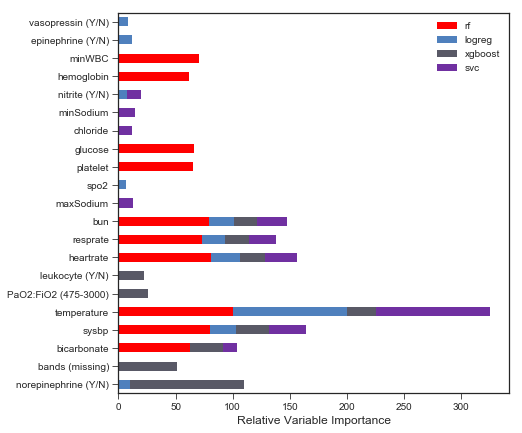

time: 479 ms


In [376]:
# features_dic_24, top_10_dic_24= model_var_imp(models_24_dic, '24_hr_window', x_train_24)
features_dic_24, top_10_dic_24= model_var_imp(models_24_dic, x_train_24)
df_base= stacked_varimp(top_10_dic_24, features_dic_24)

In [353]:
top_10_dic_24

{'logreg': spo2                    7.006959
 nitrite_1.0             7.313703
 vasopressin_1.0         8.150204
 norepinephrine_1.0      9.701868
 epinephrine_1.0        11.900351
 resprate               20.242377
 bun                    21.793059
 sysbp                  22.979157
 heartrate              25.169944
 temperature           100.000000
 dtype: float64, 'rf': hemoglobin      62.146402
 bicarbonate     62.667565
 platelet        65.695352
 glucose         66.435455
 minWBC          70.753528
 resprate        72.738136
 bun             79.697609
 sysbp           80.238640
 heartrate       81.288113
 temperature    100.000000
 dtype: float64, 'svc': chloride        11.853476
 nitrite_1.0     12.280672
 bicarbonate     12.363985
 maxSodium       12.680348
 minSodium       14.488637
 resprate        24.187938
 bun             25.917657
 heartrate       28.126466
 sysbp           32.369085
 temperature    100.000000
 dtype: float64, 'xgboost': bun                           19.9175

time: 4.71 ms


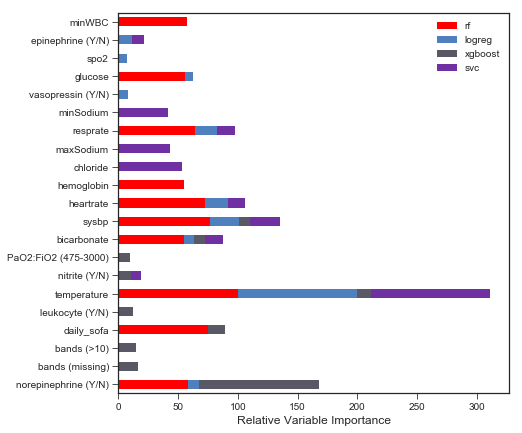

time: 605 ms


In [147]:
features_dic_48, top_10_dic_48= model_var_imp(models_48_dic, '48_hr_window', x_train_48)
df_base= stacked_varimp(top_10_dic_48, features_dic_48)

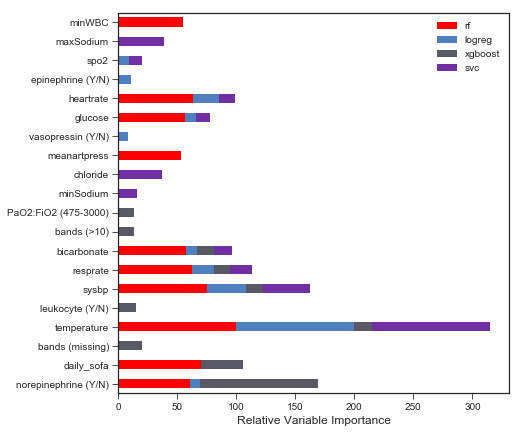

time: 481 ms


In [148]:
features_dic_72, top_10_dic_72= model_var_imp(models_72_dic, '72_hr_window', x_train_72)
df_base= stacked_varimp(top_10_dic_72, features_dic_72)

In [ ]:
#tomorrow remember to test removing SOFA score